# Setup

## Create Filesystem
This notebook is primarily meant to be executed in Colab as a computational backend. If you want to run on your own hardware with data, you need to set `data_dir` and `ALLOW_IO`

This notebook viewable directly on Colab from [https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb](https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb) (it is a mirror of github). But if it has moved branches or you are looking at a past commit, look at the [Google instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) on where to find this file.

The workflow is:
 - Data stored in (my personal/private) Google Drive
 - Utilities/library files (for importing) on github, edited on local hardware and pushed to github.
 - Notebook hosted on github, edited both in Colab or locally (depending on the relative value of having a GPU attached versus being able to use regular Jupyter keyboard shortcuts/a superior interface)

In [1]:
# Attempt Colab setup if on Colab
try:
  import google.colab
except:
  ALLOW_IO = False
else:
  # Mount Google Drive at data_dir
  #  (for data)
  from google.colab import drive
  from os.path import join
  ROOT = '/content/drive'
  DATA = 'My Drive/phutball'
  drive.mount(ROOT)
  ALLOW_IO = True
  data_dir = join(ROOT, DATA)
  !mkdir "{data_dir}"     # in case we haven't created it already   

  # Pull in code from github
  %cd /content
  github_repo = 'https://github.com/rcharan/phutball'
  !git clone -b rl {github_repo}
  %cd /content/phutball
  
  # Point python to code base
  import sys
  sys.path.append('/content/phutball/pytorch-implementation')

  # Updater for library functions changed on local hardware and pushed to github
  #  (circuitous, I know)
  def update_repo():
    !git pull

## Imports

In [3]:
%%capture

%load_ext autoreload
%autoreload 2

import os
import gc
import numpy as np

# Codebase
from lib.model_v1          import TDConway
from lib.moves             import create_placement_getter, get_jumps
from lib.utilities         import config, lfilter
from lib.testing_utilities import create_state, visualize_state, boards
from lib.timer             import Timer
from lib.moves             import END_LOC, COL, CHAIN
from lib.move_selection    import get_next_move_training
from lib.training          import training_loop

# Graphics for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.ioff()

# PyTorch
import torch

## Device Management Utilities
Setup for GPU, CPU, or (not working well/fully implemented) TPU

In [4]:
use_tpu = False

if use_tpu:
  # Install PyTorch/XLA
  VERSION = "nightly" #["20200220","nightly", "xrt==1.15.0"]
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION
  import torch_xla
  import torch_xla.core.xla_model as xm
  
  # Set the device
  device = xm.xla_device()
  
  # Memory inspection
  def print_memory_usage():
    print('TPU memory inspection not implemented')
  def print_max_memory_usage():
    print('TPU memory inspection not implemented')
  def garbage_collect():
    gc.collect() # No TPU specific implementation yet
    
elif torch.cuda.is_available():
  # Set the device
  device = torch.device('cuda')
  
  # Echo GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print(gpu_info)
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage_cuda     as print_memory_usage,
    print_max_memory_usage_cuda as print_max_memory_usage,
    garbage_collect_cuda        as garbage_collect
  )

else:
  # Set the device to CPU
  device = torch.device('cpu')
  
  # Echo RAM info
  from psutil import virtual_memory
  from lib.memory import format_bytes
  ram = virtual_memory().total
  print(format_bytes(ram), 'available memory on CPU-based runtime')
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage, 
    print_max_memory_usage,
    garbage_collect
  )

8.00GiB available memory on CPU-based runtime


# Execution

## Instantiate

In [7]:
from lib.off_policy import EpsilonGreedy
from lib.optim      import AlternatingTDLambda

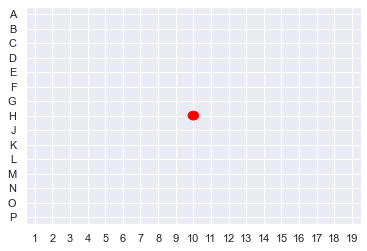

In [8]:
get_placements = create_placement_getter(device)
epsilon_greedy = EpsilonGreedy(0.1)

model = TDConway(config).to(device)
optimizer = AlternatingTDLambda(model.parameters(), 0.01, 0.9)

initial_state = create_state('H10').to(device)
visualize_state(initial_state)

## Profile

In [25]:
# Blazing fast on a P100!
# %%time
# for _ in range(1000):
get_next_move_training(initial_state, model, device);

In [ ]:
# Decently fast. 84ms/move on P100
# %%prun
training_loop(model, optimizer, 1, device, off_policy = epsilon_greedy)

## Run!

In [13]:
training_loop(optimizer, 400, off_policy = epsilon_greedy)


Playing game 1 of 400:
78/78 [==============================] - 7s 88ms/step

Playing game 2 of 400:
212/212 [==============================] - 16s 77ms/step

Playing game 3 of 400:
83/83 [==============================] - 7s 89ms/step

Playing game 4 of 400:
87/87 [==============================] - 8s 87ms/step

Playing game 5 of 400:
101/101 [==============================] - 8s 82ms/step

Playing game 6 of 400:
216/216 [==============================] - 16s 75ms/step

Playing game 7 of 400:
213/213 [==============================] - 17s 78ms/step

Playing game 8 of 400:
105/105 [==============================] - 9s 85ms/step

Playing game 9 of 400:
103/103 [==============================] - 9s 85ms/step

Playing game 10 of 400:
72/72 [==============================] - 7s 94ms/step

Playing game 11 of 400:
209/209 [==============================] - 17s 80ms/step

Playing game 12 of 400:
112/112 [==============================] - 10s 87ms/step

Playing game 13 of 400:
157/157 [======

In [0]:
def save(fname, model, optimizer):
  state_dict = {
      'model' : model.state_dict(),
      'optim' : optimizer.state_dict()
  }
  torch.save(state_dict, f'{data_dir}/{fname}.pt')

In [0]:
version = '0.1.1'
game_num = 776
save(f'v{version}-{game_num}', model, optimizer)

hello 6